# Lab 2: Prompt-learning and LoRA.

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z34asi9m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z34asi9m
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 18.8 MB/s  0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=01ea4132902b52bcf7158e93520ac4b94b2c1d9973106bcc6f37a174443eda4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-aa3gajja/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [clip]1/3 [ftfy]


In [1]:
import os
import io
import clip
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

CLASSES_CIFAR10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/users/eleves-a/2023/baptiste.arnaudo/CSC_52002_EP-MultimodalGenAI/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1. Prompt/Few-Shot learning

In this part, we will focus on prompt/few-shot learning with CLIP on the CIFAR-10 dataset.

### **Question 1.1**

Evaluate CLIP zero-shot performances on CIFAR-10.

Tip.  CIFAR-10 classes are stored in the list `CLASSES_CIFAR10`.

In [2]:
# - function to evaluate CLIP
def evaluate_clip(model, test_loader, classes, prefix, device):
    """
    Function to evaluate the model in a zero-shot setting.

    Parameters
    ----------
    model : clip model
        The model to evaluate.
    test_loader : torch.utils.data.DataLoader
        The test loader.
    classes : list
        List of classes.
    prefix : str
        Prefix to add to the classes.
        e.g. "This a photo of"
    """
    ### Comeplete the following code
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        text_inputs = torch.cat([clip.tokenize(f"{prefix} {c}") for c in classes]).to(device)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for images, labels in tqdm(test_loader):
            images = images.to(device) # B, C, H, W
            labels = labels.to(device) # B

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits_per_image = image_features @ text_features.t() # get the most likely prompt to get the class
            preds = logits_per_image.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total
    print(f"Test Acc: {test_acc:.3f}")

In [8]:
# - load the model
model, preprocess = clip.load("ViT-B/32", device=device)

# - load the data
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

/users/eleves-a/2023/baptiste.arnaudo/CSC_52002_EP-MultimodalGenAI/venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [5]:
evaluate_clip(model,
              test_loader=test_loader,
              classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"],
              prefix="",
              device=device)

100%|██████████| 79/79 [29:16<00:00, 22.24s/it]

Test Acc: 0.824


### **Question 1.2**
Explore 2 or 3 prompts to evaluate CLIP on CIFAR-10, e.g. you can use "A photo of {CLASS}".
How much can you gain by changing the prompts?

In [9]:
### Comeplete the following code

prefixes = [
    "This is a photo of",
    "There is a",
    "This image contains a",
    "This is not a photo of"] # let's try an adversarial prompt

for prefix in prefixes:
    print(f"Evaluating with prefix: '{prefix}'")
    evaluate_clip(model,
                  test_loader=test_loader,
                  classes=CLASSES_CIFAR10,
                  prefix=prefix,
                  device=device)
    print("\n")

Evaluating with prefix: 'This is a photo of'


100%|██████████| 79/79 [06:13<00:00,  4.73s/it]


Test Acc: 0.851


Evaluating with prefix: 'There is a'


100%|██████████| 79/79 [00:09<00:00,  8.60it/s]


Test Acc: 0.826


Evaluating with prefix: 'This image contains a'


100%|██████████| 79/79 [00:08<00:00,  9.72it/s]


Test Acc: 0.840


Evaluating with prefix: 'This is not a photo of'


100%|██████████| 79/79 [21:20<00:00, 16.21s/it]

Test Acc: 0.840




Weirdly, using an adversarial prompt does not decrease the performance...

## CoOp

As you may have noticed, changing the prompt can significantly impact the model's performance. However, crafting the perfect prompt is a challenging task that requires extensive experimentation. To address this issue, Context Optimization (CoOp) [Zhou et al, 2022] introduced a novel method for adapting CLIP to downstream classification tasks, bypassing the need for manual prompt engineering.

CoOp aims to learn a prompt called **learnable context** (only a few trainable parameters compared to finetuning the entire model)  to enhance the model's performance on the downstream task.


Here is a figure of the CoOp approach:

<img src="https://media.springernature.com/lw1200/springer-static/image/art%3A10.1007%2Fs11263-022-01653-1/MediaObjects/11263_2022_1653_Fig2_HTML.png" width=768>


The prompt given to the text encoder $g(·)$ will be of the form $t = [\text{SOS}][V]_1[V]_2 . . . [V]_M[\text{CLASS}][\text{EOS}]$ where each $[V]_m, (m ∈ {1, . . . , M})$ is a vector with the same dimension as word embeddings, $M$ is a hyperparameter specifying the number of context tokens, [SOS] and [EOS] are the special tokens indicating the start and end of the sentence (the same as in the pre-trained CLIP model). The context tokens $[V]_m$ are initialized randomly and learned during training. By forwarding a prompt $t$ to the text encoder g(·), we can obtain a classification weight vector representing a visual concept (still from the [EOS] token position). The prompt can then be trained using a cross-entropy between the classification weight vector and the one-hot label vector of the input image.


Let's now implement the CoOp approach.
Code-wise CoOp relies on a pretrained CLIP with a few modifications.

Note on [SOS] and [EOS] tokens:
- Tokenization is the process of converting text into a sequence of tokens, which can be words, subwords, or characters. These tokens are the smallest units of meaning in a text that can be processed by a language model. For example, the sentence “Hello, world!” can be tokenized into [“Hello”, “,”, “world”, “!”]. Tokenization simplifies the text and allows the model to work with manageable chunks of data.
- The [SOS] token is a special token that indicates the start of a sentence. The [EOS] token is a special token that indicates the end of a sentence.

### **Question 1.3**

Implement the `LearnableContext` class. This class is designed to create the learnable prompt for a CLIP model, enabling it to adapt dynamically to specific classification tasks.

The LearnableContext class should do the following:

- Initializes a set of learnable context tokens (ctx) to adapt prompts dynamically.
- Prepares token embeddings that include a prefix ([SOS] token embedding) and a suffix (class name and [EOS] tokens embedding) for each class.
- Constructs the full prompt embeddings by combining the prefix, learnable context, and suffix during the forward pass.

Example of the learnable context for CIFAR-10:
> let `X` be a learnable context token, with `n_ctx=3`, the prompt for the class "airplane" would be: `[SOS] X X X airplane [EOS]` and for the class "automobile": `[SOS] X X X automobile [EOS]`.

Tip. You can use `clip_model.token_embedding()` to get the token embeddings.

In [28]:
class LearnableContext(nn.Module):
    def __init__(self,
                 classnames,
                 clip_model,
                 device,
                 n_ctx=16):
        """
        classnames: list of str
            A list of class names for classification.
        clip_model: torch.nn.Module
            Pretrained CLIP model.
        device: str
            Device to use.
        n_ctx: int
            Number of context words to learn.
        """
        super().__init__()
        self.classnames = classnames
        self.clip_model = clip_model.float()
        self.device = device
        self.n_ctx = n_ctx
        dtype = clip_model.token_embedding.weight.dtype
        self.ctx_vectors = nn.Parameter(torch.randn(n_ctx, clip_model.transformer.width, device=device, dtype=dtype))

        classes_tokenized = clip.tokenize(classnames).to(device) # shape (num_classes, token_length)
        with torch.no_grad():
            class_embeddings = self.clip_model.token_embedding(classes_tokenized) # shape (num_classes, token_length, embedding_dim)
            self.register_buffer("prefix", class_embeddings[:, :1, :])   # (num_classes, 1, embedding_dim)  # SOS token
            suffix_len = class_embeddings.shape[1] - 1 - n_ctx
            suffix = class_embeddings[:, 1:1+suffix_len, :]  # exclude SOS and context. shape (num_classes, token_length - n_ctx - 1, embedding_dim)
        self.register_buffer("suffix", suffix) # buffer so that it is not a parameter but moves with the model to the device


    def forward(self):
        """Forward pass of the LearnableContext.

        Returns:
        -------
        torch.Tensor
            The context vector for each class: [SOS] ctx [CLASS] [EOS]
        """
        batch_size = len(self.classnames)
        ctx = self.ctx_vectors.unsqueeze(0).expand(batch_size, -1, -1)  # shape (num_classes, n_ctx, embedding_dim)
        prompt = torch.cat([self.prefix, ctx, self.suffix], dim=1)  # shape (num_classes, token_length, embedding_dim)
        return prompt

### **Question 1.4**

Implement the CoOp model.
The CoOpModel class performs the following tasks:
- Prompt Learning: Uses LearnableContext to generate learnable context tokens for each class, transforming them into dynamic text prompts.
- Text and Image Encoding: Encodes images with CLIP's visual encoder and encodes text prompts with the model's transformer and text projection.
- Logit Calculation: Computes cosine similarities between image and text features and outputs logits using a learned logit scale.

Tip:
You can implement the following methods in the CoOp Model class:
- `__init__`: Initializes the CoOp model with CLIP pretrained model (`clip.load("ViT-B/32", device="cuda")`) and the `LearnableContext` class.
- `encode_text`: Encodes the learnable prompts using the CLIP pretrained text encoder and projection head.
    It should:
    - Add the positional embedding to the input prompts (prompts).
    - Use the transformer to process the input sequence.
    - Apply the final layer normalization (ln_final) to the transformed sequence.
    - Extract the features corresponding to the end-of-text [EOS] token.
    - Project the resulting feature to the text projection space using text_projection.
    - CLIP uses a sequence-first approach for the Text model, so the input shape to the text encoder should be (sequence_length, batch_size, hidden_size).
- `forward`: Performs the forward pass computations for the CoOp model.



In [40]:
class CoOpModel(nn.Module):
    """CoOp model"""
    def __init__(self,
                 classnames,
                 clip_model,
                 device,
                 n_ctx=16):
        """Initializes the CoOp model.

        Parameters
        ----------
        classnames: list of str
            A list of class names for classification.
        clip_model: torch.nn.Module
            Pretrained CLIP model.
        device: str
            Device to use.
        n_ctx: int
            Number of context words to learn.
        """
        super().__init__()
        self.clip_model = clip_model
        self.prompt_learner = LearnableContext(n_ctx=n_ctx,
                                            device=device,
                                            classnames=classnames,
                                            clip_model=clip_model)


    def encode_text(self, prompts, tokenized_prompts):
        """
        Encodes the learnable text prompts using the CLIP model's transformer and projection layers.

        Parameters
        ----------
        prompts: torch.Tensor
            The learnable text prompts.
        tokenized_prompts: torch.Tensor
            The tokenized prompts -> the highest token in each sequence represents the [EOT].
        """
        x = prompts + self.clip_model.positional_embedding.unsqueeze(0)
        x = x.permute(1, 0, 2)  # (num_classes, token_length, embedding_dim) -> (token_length, num_classes, embedding_dim)
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # (token_length, num_classes, embedding_dim) -> (num_classes, token_length, embedding_dim)
        eot_indices = tokenized_prompts.argmax(dim=-1)  # shape (num_classes,), end of text indices
        print(eot_indices)
        x = x[torch.arange(x.shape[0]), eot_indices] @ self.clip_model.text_projection 
        return x

    def forward(self, images):
        """Given an image, returns the logits for each class."""
        prompts = self.prompt_learner()  # shape (num_classes, token_length, embedding_dim)
        tokenized_prompts = clip.tokenize(self.prompt_learner.classnames).to(self.prompt_learner.device)  # shape (num_classes, token_length)
        text_features = self.encode_text(prompts, tokenized_prompts)  # shape (num_classes, projection_dim)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)


        image_features = self.clip_model.encode_image(images)  # shape (batch_size, projection_dim)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = image_features @ text_features.t()  # shape (batch_size, num_classes)
        return logits

#### **Question 1.5**
Train CoOpModel on CIFAR-10 using a Cross Entropy loss and log both train and test loss and accuracy. Since we are in a few-shot setting, **you can only use between 1 and 20 samples per class**. You should obtain at least 85+% test accuracy.

Hparameters are to be choosen to your discretion.

Tips:
- You can use `torch.utils.data.Subset` to create a subset of the CIFAR-10 dataset with a limited number of samples per class.

In [38]:
def coop_training_loop(n_epochs,
                       n_shot,
                       device,
                       lr,
                       n_ctx,
                       batch_size,
                       classes=None):
    # -- model
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    coop_clip = CoOpModel(classnames=classes,
                        clip_model=clip_model,
                        device=device,
                        n_ctx=n_ctx
                        ).to(device)
    # -- data
    train_transform = preprocess
    test_transform = preprocess
    train_set = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
    test_set = torchvision.datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

    # -- few-shot sampler
    def few_shot_sampler(dataset, n_shot, classes):
        """Returns a subset of the dataset with n_shot examples per class."""
        class_count = {i: 0 for i in range(len(classes))}
        indices = []
        for idx, label in enumerate(dataset.targets):
            if class_count[label] < n_shot:
                indices.append(idx)
                class_count[label] += 1
            if all(class_count[i] >= n_shot for i in class_count):
                break
        return torch.utils.data.Subset(dataset, indices)

    few_shot_train_set = few_shot_sampler(train_set, n_shot, classes)
    train_loader = torch.utils.data.DataLoader(few_shot_train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # -- optimizer
    optimizer = torch.optim.AdamW(coop_clip.prompt_learner.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # -- training loop
    for epoch in range(n_epochs):
        coop_clip.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = coop_clip(images)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            preds = logits.argmax(dim=-1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        train_acc = correct_train / total_train
        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Acc: {train_acc:.3f}")

        # test loss
        coop_clip.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images = images.to(device)
                labels = labels.to(device)

                logits = coop_clip(images)
                loss = loss_fn(logits, labels)

                test_loss += loss.item() * images.size(0)

                preds = logits.argmax(dim=-1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
        avg_loss = test_loss / len(test_loader.dataset)
        test_acc = correct_test / total_test
        print(f"Test Loss: {avg_loss:.4f}")
        print(f"Test Acc: {test_acc:.3f}")

In [ ]:
# Nothing works because the prompting is wrong

coop_clip_trained = coop_training_loop(n_epochs=35,
                                device=device,
                                n_shot=20,
                                lr=0.001,
                                n_ctx=12,
                                batch_size=32,
                                classes=CLASSES_CIFAR10)

/users/eleves-a/2023/baptiste.arnaudo/CSC_52002_EP-MultimodalGenAI/venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
  0%|          | 0/7 [00:00<?, ?it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.58 GiB of which 8.19 MiB is free. Process 3415704 has 2.41 GiB memory in use. Including non-PyTorch memory, this process has 12.74 GiB memory in use. Process 3862274 has 282.00 MiB memory in use. Of the allocated memory 11.90 GiB is allocated by PyTorch, and 645.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


# Part 2: LoRA (low-rank adaptation)

### **What is LoRA?**

LoRA, or **Low-Rank Adaptation**, is a technique designed to **fine-tune large pre-trained models efficiently** by introducing learnable low-rank matrices into their architecture. Instead of updating all the weights of a large model (which can be computationally expensive and require a lot of storage), LoRA updates a small set of parameters while keeping the original model frozen. This drastically reduces the computational overhead and memory usage during fine-tuning.

---

### **Why LoRA?**

- **Efficiency:** Reduces the number of trainable parameters significantly.
- **Scalability:** Works well for large models like transformers but can also be applied to simpler models like MLPs.
- **Parameter Isolation:** Fine-tuning multiple tasks without interfering with each other is easier as the low-rank adapters can be task-specific.

---

### **How LoRA Works**

1. **Key Idea:** Approximates the weight update \( \Delta W \) in a neural network using the product of two low-rank matrices \( A \) and \( B \):
   $$
   W' = W + \Delta W, \quad \Delta W = A \cdot B
   $$
   - \( A \) and \( B \) are much smaller matrices (rank \( r \)) compared to the original weight matrix \( W \).

2. **Freezing the Model:** The original model’s weights \( W \) remain frozen during fine-tuning. Only \( A \) and \( B \) are updated, which are much smaller in size.

3. **Low-rank Design:** By choosing a small rank \( r \), LoRA ensures that the added parameters are minimal while still allowing the model to adapt to new tasks.

---

### **LoRA in MLPs**

- **Today:** Let's first do a small toy-example of LoRA on MLP to understand how LoRA works




In [2]:
import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(0) # reproducibility

Let’s generate a **toy dataset** with random data for a classification task. The dataset includes a small amount of meaningful signal, allowing the model’s loss to improve during training as it learns to identify patterns.

In [3]:
X = torch.rand((1000, 20)) # Returns a tensor filled with random numbers from a uniform distribution on the interval [0,1).
# I modified this line to be consistent with the commentary (the 0.5 was a 0)
y = (torch.sin(X.sum(1)) > 0.5).long() # y is the label with shape (1000, 1) which results in 1 if the sin of sum of elements in each row is > 0.5 and 0 otherwise. y is then cast to (torch.int64).

In [4]:
# Distribution of data between both classes
unique, counts = torch.unique(y, return_counts=True)
distribution = dict(zip(unique.tolist(), counts.tolist()))
distribution

{0: 805, 1: 195}

In [5]:
n_train = 800
batch_size = 64

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X[:n_train], y[:n_train]),
    batch_size=batch_size,
    shuffle=True,
)
eval_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X[n_train:], y[n_train:]),
    batch_size=batch_size,
)

We use a simple multilayer perceptron (**MLP**). For demonstration purposes, we use a very large number of hidden units. This is totally an **overkill** for this task but it helps to demonstrate the advantages of `peft`. In more realistic settings, models will also be quite large on average, so this is not far-fetched.

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            # Complete the following code for a 3 layer MLP,
            # with a big middle layer dim > 2000
            nn.Linear(20, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048), # two classes: either 0 or 1
            nn.ReLU(),
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim=-1), #log loss / binary cross entropy loss
        )

    def forward(self, X):
        return self.seq(X)

Here are just a few training hyper-parameters and a simple function that performs the training and evaluation loop.

In [30]:
lr = 0.002
batch_size = 64
max_epochs = 35
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
print(device)

cuda


In [40]:
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, epochs, device, output):
    train_losses = []
    eval_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for xb, yb in train_bar:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            train_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss_total = train_loss / len(train_dataloader)
        train_losses.append(train_loss_total)

        # Evaluation step
        model.eval()
        eval_loss = 0

        eval_bar = tqdm(eval_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Eval]", leave=False)
        for xb, yb in eval_bar:
            xb = xb.to(device)
            yb = yb.to(device)
            with torch.no_grad():
                outputs = model(xb)
                loss = criterion(outputs, yb)
                eval_loss += loss.detach().item()

        eval_loss_total = eval_loss / len(eval_dataloader)
        eval_losses.append(eval_loss_total)

    # Save the training curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, epochs + 1), eval_losses, label="Eval Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(output)

### **Question 2.1**:
Please complete the following code for this toy example:
- base_model
- optimizer
- criterion (loss)

In [41]:
base_model = MLP().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr)
criterion = nn.NLLLoss() # because we already output log softmax in the model

In [11]:
base_model

MLP(
  (seq): Sequential(
    (0): Linear(in_features=20, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    ### Complete me
    for param in model.parameters():
        num_params = param.numel() # number of elements in a PyTorch tensor
        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Show trainable params

In [13]:
print_trainable_parameters(base_model)

trainable params: 47106 || all params: 47106 || trainable%: 100.0


### **Question 2.2**:

**Question:**
Explain your observations regarding the training behavior and performance on the new 'MLP' regarding the training and eval loss.

---

**Answer your observations here:**

We can clearly see that the model is overfitting the training data. The train loss decreases significantly, indicating that the model is learning to fit the training data well. However, the eval loss first decreases but then starts to increase again, suggesting that the model is not generalizing well to unseen data. This behavior is typical in scenarios where the model has a large capacity (many parameters) relative to the amount of training data, leading to overfitting. This is our case here, where the function to approximate is relatively simple compared to the model's capacity (which is high because of the large hidden layer size).

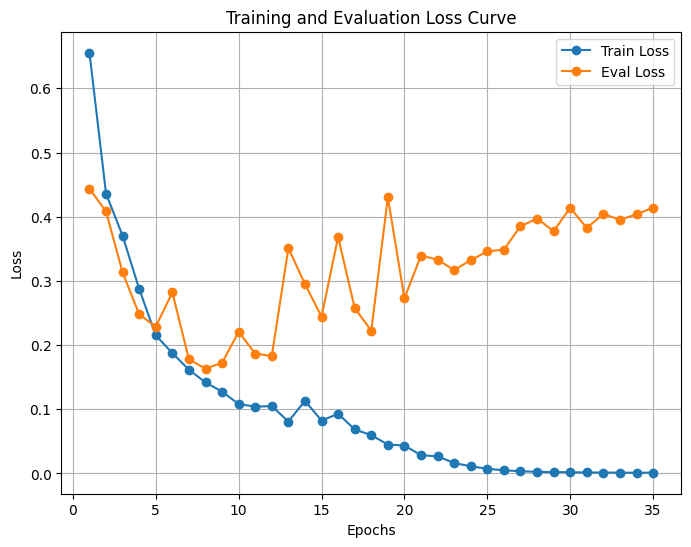

<Figure size 640x480 with 0 Axes>

In [42]:
# Lets train the base model
train(base_model, optimizer, criterion, train_dataloader, eval_dataloader, epochs=max_epochs, device=device, output="./base_model_training_curve.png")

### **Question 2.3**

Now, we will implement the `LoRALinear` layer as a replacement for the standard `Linear` layer. This involves defining the following LoRA-specific parameters:
- `low_rank_A`
- `low_rank_B`
- `rank`

Additionally, we also include the necessary code to facilitate training.

**Question:**
Explain your observations regarding the training behavior and performance on the new 'LoRAMLP'

---

**Answer your observations here:**

👉 **[YOUR ANSWER]**

In [64]:
import torch.nn as nn

class LoRALinear(nn.Linear):
    def __init__(self, in_features, out_features, rank, bias=True):
        """
        LoRALinear layer with low-rank adaptation.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            rank (int): Rank of the low-rank matrices for LoRA.
            bias (bool): Whether to include a bias term.
        """
        super().__init__(in_features, out_features, bias=bias)

        # LoRA-specific parameters
        ### Complete the following code of low_rank_A, low_rank_B and rank
        self.rank = rank
        self.low_rank_A = nn.Parameter(torch.zeros((rank, in_features)))  # Shape (r, in_features)
        self.low_rank_B = nn.Parameter(torch.zeros((out_features, rank)))  # Shape (out_features, r)

        # Initialize LoRA parameters
        self.reset_lora_parameters()

    def reset_lora_parameters(self):
        """Initialize LoRA-specific parameters."""
        nn.init.kaiming_uniform_(self.low_rank_A, a=5 ** 0.5)
        nn.init.kaiming_uniform_(self.low_rank_B, a=5 ** 0.5)

    def forward(self, input):
        """
        Perform forward pass with LoRA adaptation.

        Args:
            input (Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            Tensor: Output tensor of shape (batch_size, out_features).
        """
        ### Complete the following code of computing adapted weight: Original weight + low-rank update
        adapted_weight = self.weight + torch.matmul(self.low_rank_B, self.low_rank_A)  # Shape (out_features, in_features)
        return torch.nn.functional.linear(input, adapted_weight, self.bias)

class LoRA_MLP(nn.Module):
    def __init__(self, lora_rank):  # Default rank for LoRA
        super().__init__()
        ### Complete the following code of: LoRA_MLP
        ### Use the created LoRALinear
        self.seq = nn.Sequential(
            nn.Linear(20, 2048),
            nn.ReLU(),
            LoRALinear(2048, 2048, rank=lora_rank), # we replace the large middle layer with LoRALinear
            nn.ReLU(),
            nn.Linear(2048, 2),
            nn.LogSoftmax(dim=-1),
        )


    def forward(self, X):
        return self.seq(X)

In [60]:
def freeze_non_lora_parameters(model):
    ### Complete the following code of: freezing none lora parameters,
    ### consider also make the last linear layer trainable
    for name, param in model.named_parameters():
        if 'low_rank_A' in name or 'low_rank_B' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
        if 'seq.4' in name:  # Make the last linear layer trainable
            param.requires_grad = True

In [66]:
# use it
lora_model = LoRA_MLP(lora_rank=8).to(device)  # You can adjust the rank as needed
freeze_non_lora_parameters(lora_model)
print_trainable_parameters(lora_model)
##
optimizer = torch.optim.Adam(lora_model.parameters(), lr=lr)

trainable params: 36866 || all params: 4276226 || trainable%: 0.8621153325385515


This time there are only ~1% of the parameters that are trainable!

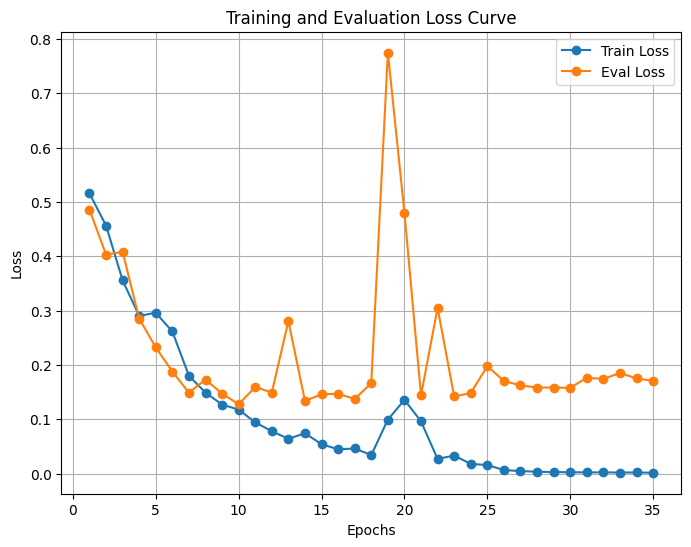

<Figure size 640x480 with 0 Axes>

In [67]:
train(lora_model, optimizer, criterion, train_dataloader, eval_dataloader, device=device, epochs=max_epochs, output="./lora_model_training_curve.png")

Training LoRA model with rank 4


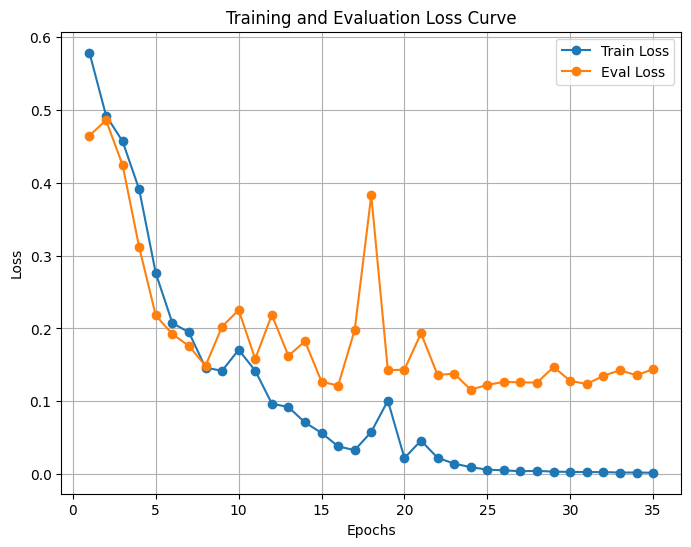

Training LoRA model with rank 8


<Figure size 640x480 with 0 Axes>

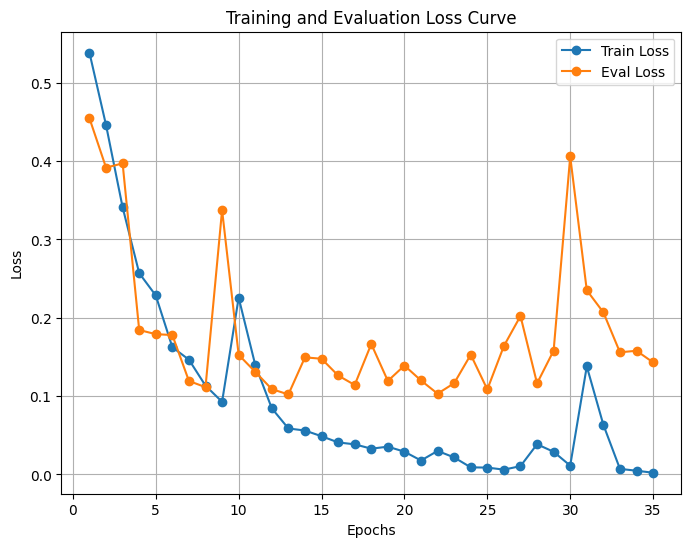

Training LoRA model with rank 16


<Figure size 640x480 with 0 Axes>

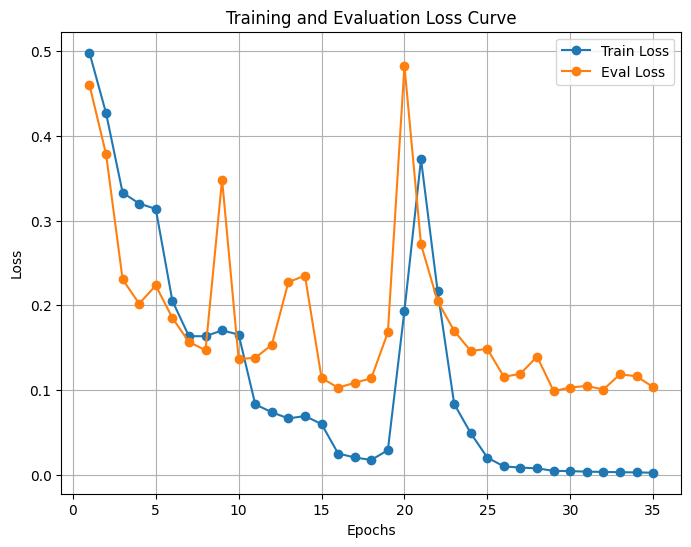

Training LoRA model with rank 32


<Figure size 640x480 with 0 Axes>

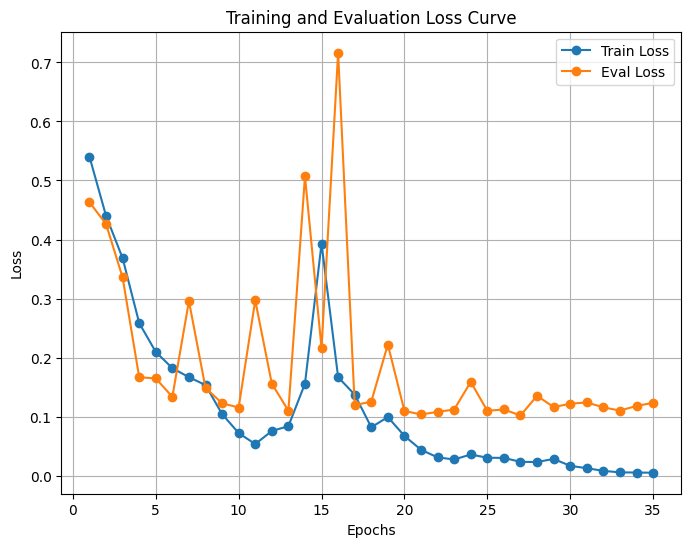

<Figure size 640x480 with 0 Axes>

In [72]:
ranks = [4, 8, 16, 32]
for rank in ranks:
    print(f"Training LoRA model with rank {rank}")
    lora_model = LoRA_MLP(lora_rank=rank).to(device)
    freeze_non_lora_parameters(lora_model)
    optimizer = torch.optim.Adam(lora_model.parameters(), lr=lr)
    train(lora_model, optimizer, criterion, train_dataloader, eval_dataloader, device=device, epochs=max_epochs, output=f"./lora_model_training_curve_rank_{rank}.png")

We can see that the test loss decreases when we increase the rank, but seems to stabilize after rank 8. Moreover, the test loss doesn't go back up as in the previous case, indicating that the model is generalizing better to unseen data. This suggests that LoRA is effective in allowing the model to adapt to the task without overfitting, even with a significantly reduced number of trainable parameters. The low-rank adaptation seems to provide enough flexibility for the model to learn the underlying patterns in the data while maintaining good generalization performance.

## **Introduction to PEFT (Parameter-Efficient Fine-Tuning)**

In this lab, we’ve manually implemented LoRA for fine-tuning very simple MLP and Linear but this adapatation can be tedious to manage custom layers, weight transfers, and freezing parameters.

Instead, we can use **Hugging Face's PEFT (Parameter-Efficient Fine-Tuning)** library. PEFT provides tools to easily integrate techniques like LoRA into your training pipeline without writing custom implementations. It automates tasks such as:
- Adding low-rank layers to the model.
- Freezing non-LoRA parameters.
- Managing weight transfers and training only the LoRA-specific parameters.

In the next part of this lab, we redo everything with peft library.

In [54]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 14.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 50.1 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 19.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.7 MB/s  0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface_hub 1.3.1
    Uninstalling huggingface_hub-1.3.1:━━━━━━━━━ 0/5 [huggingface_hub]
      Successfully uninstalled huggingface_hub-1.3.12m0/5 [huggingface_hub]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [peft]4/5 [peft]erate]s]


In [55]:
import peft
import copy

We list all names of the modules to decide which put into lora config

In [56]:
[(n, type(m)) for n, m in MLP().named_modules()]

[('', __main__.MLP),
 ('seq', torch.nn.modules.container.Sequential),
 ('seq.0', torch.nn.modules.linear.Linear),
 ('seq.1', torch.nn.modules.activation.ReLU),
 ('seq.2', torch.nn.modules.linear.Linear),
 ('seq.3', torch.nn.modules.activation.ReLU),
 ('seq.4', torch.nn.modules.linear.Linear),
 ('seq.5', torch.nn.modules.activation.LogSoftmax)]

Next we can define the LoRA config. There is nothing special going on here. We set the LoRA rank to 8 and select the layers `seq.0` and `seq.2` to be used for LoRA fine-tuning. As for `seq.4`, which is the output layer, we set it as `module_to_save`, which means it is also trained but no LoRA is applied.

In [57]:
config = peft.LoraConfig(
    r=2,
    target_modules=["seq.0", "seq.2"],
    modules_to_save=["seq.4"],
)

In [81]:
module = MLP().to(device)
peft_model = peft.get_peft_model(module, config)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
criterion = nn.NLLLoss()

Now you can complete train the LoRA with `peft_model` directly, **complete the code.**

trainable params: 16,426 || all params: 4,259,884 || trainable%: 0.3856


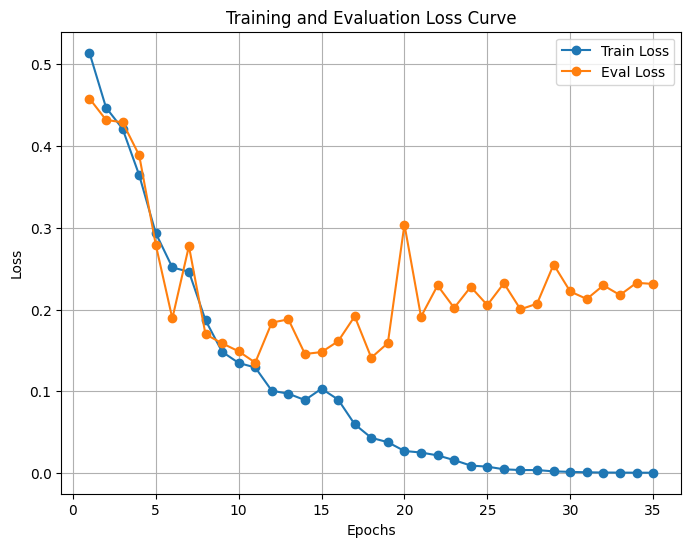

<Figure size 640x480 with 0 Axes>

In [82]:
### Complete the following code:
peft_model.print_trainable_parameters()
train(peft_model, optimizer, criterion, train_dataloader, eval_dataloader, device=device, epochs=max_epochs, output="./peft_model_training_curve.png")

### **Using LoRA to fine-tune CLIP**


### Reuse dataset Food101
Implement the dataset class for UPMC-Food101 dataset.
For this, you will need to:
- Download the data [here](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing)
- Split it in train, val, test sets using the following ratios: 0.7, 0.1, 0.2.
- Create a dataset class inherited from `torch.utils.data.Dataset` that loads the data, and preprocesses it.

Tips:
1. In `PyTorch`, the dataset class should inherint from [`torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/data_loading_tutorial#dataset-class) and always override:
- `__len__`: so that `len(dataset)` returns the size of the dataset.
- `__getitem__`: to support the indexing such that `dataset[i]` can be used to get the `i`-th sample.


2. If you use colab, to ease the access to the data, you can mount your google drive and access the data from there.
- *Mount your Google Drive* to allow Colab to access files in your Drive.
```python
from google.colab import drive
drive.mount('/content/drive')
```
- Access the [file](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing) with the data, this will automatically add it to your 'shared folder'
- Locate the Shared Folder which is typically stored under My Drive > Shared with me. (However, only items in "My Drive" or folders you’ve added to your Drive can be accessed directly.)
- Add the Shared Folder to 'My Drive'. Drag & drop the folder in 'My Drive' folder.
- The folder with the data should now be in My Drive/LabeledDB_new
- It should now be located in the path '/content/drive/My Drive/food101.arrow'

In [85]:
DATA_DIR = "./data"

In [84]:
!pip install peft
!pip install pyarrow

import os
import io
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

from transformers import CLIPProcessor, CLIPModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def open_arrow(data_dir, name):
    path = os.path.join(data_dir, f"{name}.arrow")
    assert os.path.isfile(path)
    table = pa.ipc.RecordBatchFileReader(
        pa.memory_map(path, "r")
    ).read_all()
    all_texts = table["text"].to_pandas().to_list()
    all_texts = [text[0] for text in all_texts]
    all_images = table["image"].to_pandas().to_list()
    all_labels = table["label"].to_pandas().to_list()
    return all_texts, all_images, all_labels

CLASSES_FOOD101 = [
        "frozen yogurt", "tacos","gnocchi", "ramen", "sushi", "spaghetti carbonara", "foie gras", "club sandwich",
        "chicken curry", "caprese salad", "guacamole", "fish and chips", "seaweed salad", "samosa", "shrimp and grits",
        "prime rib", "cheese plate", "grilled cheese sandwich", "omelette", "macarons", "pancakes", "paella",
        "crab cakes", "onion rings", "poutine", "panna cotta", "hamburger", "eggs benedict", "pizza", "cup cakes",
        "red velvet cake", "huevos rancheros", "french toast", "pad thai","beef tartare", "beet salad",
        "garlic bread", "escargots", "cheesecake", "tuna tartare", "french fries", "pulled pork sandwich", "ravioli",
        "clam chowder", "baby back ribs", "pork chop", "chicken quesadilla", "grilled salmon", "dumplings",
        "fried rice", "macaroni and cheese", "hot and sour soup", "tiramisu",  "lobster_roll_sandwich",
        "filet mignon",  "lobster bisque",  "risotto",  "takoyaki",  "waffles",  "miso soup",  "scallops",
        "hummus", "french onion soup", "spaghetti bolognese", "gyoza", "sashimi", "caesar salad",
        "donuts", "pho", "creme brulee", "edamame","apple pie", "carrot cake", "croque madame",
        "chocolate_cake", "mussels", "chocolate mousse", "deviled eggs", "ice cream",
        "chicken_wings", "steak", "churros", "beignets", "breakfast burrito", "spring rolls",
        "lasagna", "cannoli", "nachos", "bruschetta", "hot dog", "greek salad", "beef carpaccio",
        "falafel", "strawberry shortcake", "bread pudding", "ceviche", "peking duck",
        "bibimbap", "oysters", "fried calamari", "baklava"
    ]

In [91]:
splits = {"train" : 0.7, "val" : 0.1, "test" : 0.2}

Use directly the code from last week.

In [92]:
class MultimodalDataset(torch.utils.data.Dataset):
    """Food101 dataset."""

    def __init__(
        self,
        path: str,
        name: str, 
        split: str = None,
        img_transforms = None,
    ) -> None:
        """Initialize Food101 dataset.

        Parameters
        ----------
        path : str
            Path where the dataset is stored.
        name: str
            Name of the file to load.
        split : str, optional
            Split to use, by default None.
        img_transforms : torchvision.transforms, optional
            Image transformations, by default None.
        split : str, optional
            split to use, e.g. "train", "val", "test".
        """
        super().__init__()
        self.texts, self.images, self.labels = open_arrow(path, name)
        self.img_transforms = img_transforms
        self.indices = np.arange(len(self.texts))
        self.indices = np.random.default_rng(42).permutation(self.indices)
        if split is not None:
            assert split in splits, f"Split {split} not recognized. Available splits: {list(splits.keys())}"
            total_size = len(self.texts)
            split_size = int(total_size * splits[split])
            if split == "train":
                self.indices = self.indices[:split_size]
            elif split == "val":
                start_idx = int(total_size * splits["train"])
                end_idx = start_idx + split_size
                self.indices = self.indices[start_idx:end_idx]
            elif split == "test":
                start_idx = int(total_size * (splits["train"] + splits["val"]))
                self.indices = self.indices[start_idx:]
        

    def __len__(self):
        """Len of the dataset."""
        return len(self.indices)

    def __getitem__(self, index):
        """Get one item from the dataset of the given index.
        
        Parameters
        ----------
        index : int
            Index of the item to get.
        """
        i = self.indices[index]
        image = Image.open(io.BytesIO(self.images[i])).convert("RGB")
        if self.img_transforms:
            image = self.img_transforms(image)
        text = self.texts[i]
        label = self.labels[i]
        return image, text, label
        

Make sure the dataset works fine.

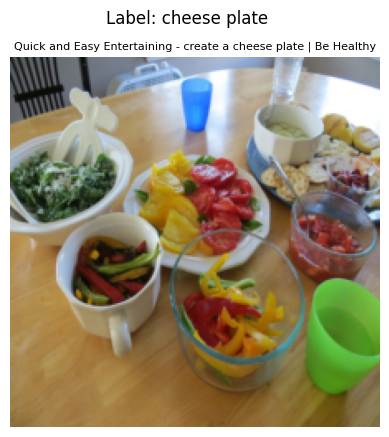

In [93]:
im_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])
idx = 2
dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=im_transforms,)
# - display one image
image, text_value, label  = dataset[idx]
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.suptitle(f'Label: {CLASSES_FOOD101[label]}')
plt.title(text_value, fontsize=8)
plt.axis('off')
plt.show()

Again we evaluate the zero-shot performance of the CLIP model on the UPMC-Food101 dataset. Use `clip.tokenize(text_labels)` to tokenize the text labels and `clip.load("ViT-B/32", device=device)[0]` to load the CLIP pretrained model.

In [94]:
img_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
        ),
    ])

test_set_food = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=img_transforms)
test_loader_food = torch.utils.data.DataLoader(test_set_food, batch_size=128, shuffle=False)

In [98]:
def evaluate_clip_multimodal_hf(model, processor, test_loader, classes, prefix, device):
    """
    Evaluate a CLIP model (Hugging Face) on a classification task.

    Args:
        model (CLIPModel): A Hugging Face CLIP model.
        processor (CLIPProcessor): A Hugging Face CLIP processor for tokenizing and image preprocessing.
        test_loader (DataLoader): DataLoader for the test set, yielding (images, _, labels).
        classes (list): List of class labels.
        prefix (str): Text prefix for prompt engineering (e.g., "A photo of a").
        device (torch.device): The device (CPU or GPU) to perform evaluation on.
    """
    # Prepare text prompts (labels)
    text_labels = [f"{prefix}{c}" for c in classes]  # e.g., "A photo of a dog"

    # Tokenize text labels with HF processor
    text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)

    test_acc = 0.0
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images, _, labels = batch
            labels = labels.to(device)

            # Preprocess images
            image_inputs = processor(images=images, return_tensors="pt",
                                     do_normalize=False, do_resize=False, do_rescale=False,).to(device)

            outputs = model(**image_inputs, **text_inputs)
            logits_per_image = outputs.logits_per_image  # (batch_size, num_classes)

            probs = logits_per_image.softmax(dim=-1).cpu()
            predicted = probs.argmax(dim=-1)

            test_acc += (predicted == labels.cpu()).sum().item()
            all_labels.append(labels.cpu())
            all_predictions.append(predicted)

    test_acc /= len(test_loader.dataset)
    print(f"Test Acc: {test_acc:.3f}")

# Initialize the Hugging Face CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Evaluate the model
evaluate_clip_multimodal_hf(
    model=model,
    processor=processor,
    test_loader=test_loader_food,
    classes=CLASSES_FOOD101,
    prefix="",
    device=device
)

RemoteEntryNotFoundError: 404 Client Error. (Request ID: Root=1-696b49de-5137ced7481f76a8423bd374;c20db305-562d-4dbc-a0d4-ea7d7fdc0be5)

Entry Not Found for url: https://huggingface.co/api/models/openai/clip-vit-base-patch32/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

### Question 2.4:
Now we use the peft library to fine-tune our clip more efficiently.


In [ ]:
batch_size=128
im_transforms_train = torchvision.transforms.Compose(
    [transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop but keep most of food visible
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        IMAGENET_DEFAULT_MEAN,
        IMAGENET_DEFAULT_STD
    ), ]
    )
im_transforms = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
    ),
])
dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="train",
                            img_transforms=im_transforms_train)
test_dataset = MultimodalDataset(path=DATA_DIR,
                        name="food101",
                        split="test",
                        img_transforms=im_transforms)
val_dataset = MultimodalDataset(path=DATA_DIR,
                                name="food101",
                                split="val",
                                img_transforms=im_transforms)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        drop_last=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            drop_last=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=False)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

In [ ]:
def train_clip_lora(
    model,
    processor,
    train_loader,
    val_loader,
    classes,
    epochs=5,
    lr=1e-3,
    prefix="",
):
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            ### Complete the training and the validataion
        print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f}")

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
# device="cpu"
# Example LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Adjust to match your model's layer names
    lora_dropout=0.1,
    bias="none",
)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

lora_model = get_peft_model(model, lora_config)
print_trainable_parameters(lora_model)

print(len(CLASSES_FOOD101))

Fine-tune with LoRA
train_clip_lora(
    model=lora_model,
    processor=processor,
    train_loader=dataloader,
    val_loader=val_dataloader,
    classes=CLASSES_FOOD101,
    epochs=5,
    lr=1e-3,
    prefix=""  # example prompt, try also the prompting if you want
)


Evaluate your lora-model to see if the lora helps the tuning.

In [ ]:
evaluate_clip_multimodal_hf(
    model=lora_model,
    processor=processor,
    test_loader=test_loader_food,
    classes=CLASSES_FOOD101,
    prefix="",
    device=device
)